# Install and import what is necessary to carry out the training

In [4]:
#Importing libraries and mounting the drive where the dataset is stored
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style(style = 'whitegrid')
import sys
print(sys.version)
import logging
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install datasets
!pip install transformers==4.28.0
!pip install evaluate
!pip install wandb
import tensorflow as tf
import gc, torch
from datasets import load_dataset
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding, TextClassificationPipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import transformers

# Defining common training functions to all models

In [ ]:
def load_corpus_Twitch(drop, n_labels, task):
  dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/TFG/CorpusTwitchVideojuegos.xlsx")
  dataset.columns = ["text", "label", "emotion"]
  dataset.drop(dataset.tail(drop).index, inplace = True)
  if(task=="sentiment"):
    if(n_labels==2):
      dataset = dataset.loc[dataset["label"] != "Indeterminado"]
      dataset['label'] = [0 if item=="Negativo" else 1 for item in dataset['label']]
    else:
      dataset['label'] = [0 if item=="Negativo" else 1 if item=="Indeterminado" else 2 for item in dataset['label']]
    return dataset[["text", "label"]]
  else:
    dataset['label'] = [0 if item=="Decepción/Tristeza" else 1 if item=="Aprobación/Empatía/Confianza" else 2 if item=="Enfado/Ira" else 3 if item=="Interés/Anticipación/Hype" else 4 if item=="Desaprobación" else 5 for item in dataset['emotion']]


    return dataset[["text", "label"]]    #Mandatory for headers to be ["text", "label"] for trainer

#Label "Texto" is Text
#Label "Emociones" is Emotions

#Label "Positiva" is Positive
#Label "Negativa" is Negative
#Label "Indeterminado" is Neutral

#Label Aprobación is Approval/Empathy/Confidence
#Label Desaprobación is Disapproval
#Label Decepción/Tristeza is Disappointment/Sadnes
#Label Enfado/Ira is Anger
#Label Interés/Aceptación/Hype is Interest/Acceptance/Hype
#Label Indeterminado is Neutral


def compute_metrics(eval_pred):
    metric1 = evaluate.load("accuracy")
    metric2 = evaluate.load("precision")
    metric3 = evaluate.load("recall")
    metric4 = evaluate.load("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]
    precision = metric2.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = metric3.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    f1 = metric4.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1}


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def garbage_collector():
  torch.cuda.empty_cache()
  gc.collect()
  !nvidia-smi

earlyStop=EarlyStoppingCallback()

# Analysis of Polarity in the Twitch and Video Games Corpus

   TEXTO Polaridad
0     99  Negativo
1     <3  Positivo
2     =D  Positivo
3   ♥♥♥♥  Positivo
4   3/10  Negativo


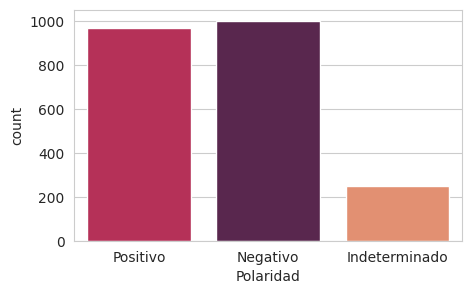

In [6]:
#Label "Polaridad" is Polarity
#Label "Positiva" is Positive
#Label "Negativa" is Negative
#Label "Indeterminado" is Neutral

dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/TFG/CorpusTwitchVideojuegos.xlsx")[["TEXTO", "Polaridad"]]

print(dataset.head())

plt.figure(figsize=(5, 3))
sns.countplot(x = 'Polaridad', data = dataset, hue = 'Polaridad', palette = 'rocket', legend = False, order=['Positivo', 'Negativo', 'Indeterminado']);

In [7]:
print(len(dataset[dataset["Polaridad"]=="Positivo"]))
print(len(dataset[dataset["Polaridad"]=="Negativo"]))
print(len(dataset[dataset["Polaridad"]=="Indeterminado"]))

#Label "Polaridad" is Polarity
#Label "Positiva" is Positive
#Label "Negativa" is Negative
#Label "Indeterminado" is Neutral

968
1000
247


### RoBERTuito Model with 2 labels: Positive, Negative

##### Tunning process of the BERT model with Wandb

In [10]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [9]:
id2label = {0: "NEG", 1: "POS"}
label2id = {"NEG": 0, "POS": 1}

#NEG is Negative Polarity
#POS is Positive Polarity

model = AutoModelForSequenceClassification.from_pretrained('pysentimiento/robertuito-sentiment-analysis', num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-sentiment-analysis')
data_collator = DataCollatorWithPadding(tokenizer)


dataset = load_corpus_Twitch(drop=0, n_labels=2, task="sentiment")
train, test = train_test_split(dataset, stratify=dataset["label"])
train.to_csv("corpus_train.csv", index=False)
test.to_csv("corpus_test.csv", index=False)
train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
tokenized_datasets = train_test.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

In [ ]:
config = {
          "wandb":{
            "project": "wandb-2labels-Twitch",
            "api_key": "XXXXXXXX"
        }
}


def wandb_hp_space(trial):
    return {
        "method": "random",
        "metric": {"name": "accuracy", "goal": "maximize"},
        "parameters": {
            "learning_rate": {"distribution": "uniform", "min": 1e-6, "max": 1e-4},
            "per_device_train_batch_size": {"values": [16, 32, 64, 128]},
            "per_device_eval_batch_size": {"values": [16, 32, 64, 128]},
            "num_train_epochs" : {"distribution": "int_uniform", "min": 5, "max": 15}
        },
    }

def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
        'pysentimiento/robertuito-sentiment-analysis',
        config=config
    )


training_args = TrainingArguments(report_to="wandb", output_dir="wandb-2labels-Twitch", overwrite_output_dir=True,
       evaluation_strategy="epoch", per_device_train_batch_size = 128, per_device_eval_batch_size=128, num_train_epochs = 10,
                                    fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator,
    callbacks=[earlyStop]
)

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="wandb",
    hp_space=wandb_hp_space,
    n_trials=30
)
# n_triasl = 10 (inicial)

wandb.finish()

##### KFold Process

In [ ]:
dataset = load_corpus_Twitch(drop=0, n_labels=2, task="sentiment")
id2label = {0: "NEG", 1: "POS"}
label2id = {"NEG": 0, "POS": 1}

#NEG is Negative Polarity
#POS is Positive Polarity

#Number of splits in the training data
splits=10

#dataframes
NEG = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
POS = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
macro = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
weighted = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
acc= pd.DataFrame(columns=["accuracy"])

i=0
kf = StratifiedKFold(n_splits = splits, random_state=10, shuffle=True)
for train, test in kf.split(X=dataset["text"], y=dataset["label"]):
  print("\n\n******************Loop", i, "**************************\n\n")


  #the model must be created a new in each iteration because otherwise the following runs are made with the weights of previous runs, giving overfitting
  model = AutoModelForSequenceClassification.from_pretrained('pysentimiento/robertuito-sentiment-analysis', num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
  tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-sentiment-analysis')
  data_collator = DataCollatorWithPadding(tokenizer)

  #the best training arguments obtained in the tuning process of the model (highest accuracy)
  training_args = TrainingArguments(learning_rate=0.00009517, num_train_epochs=7, per_device_train_batch_size = 64, per_device_eval_batch_size=128, #best-sweep-14
                                  output_dir="best-sweep-", evaluation_strategy="epoch", fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

  dataset.iloc[train].to_csv("corpus_train.csv", index=False)
  dataset.iloc[test].to_csv("corpus_test.csv", index=False)
  train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
  tokenized_datasets = train_test.map(tokenize_function, batched=True)


  trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=[earlyStop]
  )
  trainer.train()
  pred=trainer.predict(tokenized_datasets["test"])
  logits=pred.predictions
  prob=tf.nn.softmax(logits)
  res=np.argmax(prob, axis=1) #predictions based on the labels

  report = classification_report(tokenized_datasets["test"]["label"], res, output_dict=True)
  NEG.loc[i] = report["0"]
  POS.loc[i] = report["1"]
  macro.loc[i] = report["macro avg"]
  weighted.loc[i] = report["weighted avg"]
  acc.loc[i] = report["accuracy"]
  i+=1






In [ ]:
NEG

In [ ]:
print(np.mean(NEG, axis=0))
#metrics for the Negative class

In [ ]:
POS

In [ ]:
print(np.mean(POS, axis=0))
#metrics for the Positive class

In [ ]:
macro

In [ ]:
print(np.mean(macro, axis=0))

In [ ]:
weighted

In [ ]:
print(np.mean(weighted, axis=0))

In [ ]:
acc

In [ ]:
print(np.mean(acc, axis=0))
#metrics for the global accuracy of the model

### RoBERTuito Model with 3 labels: Positive, Negative, Neutral

##### Tuning process of the BERT model with wandb

In [ ]:
import wandb

wandb.login()

In [ ]:
id2label = {0: "NEG", 1: "NEU", 2: "POS"}
label2id = {"NEG": 0, "NEU": 1, "POS": 2}

#NEG is Negative Polarity
#POS is Positive Polarity
#NEU is Neutral Polarity

model = AutoModelForSequenceClassification.from_pretrained('pysentimiento/robertuito-sentiment-analysis', num_labels=3, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-sentiment-analysis')
data_collator = DataCollatorWithPadding(tokenizer)


dataset = load_corpus_Twitch(drop=0, n_labels=3, task="sentiment")
train, test = train_test_split(dataset, stratify=dataset["label"])
train.to_csv("corpus_train.csv", index=False)
test.to_csv("corpus_test.csv", index=False)
train_test = load_dataset("csv", data_files={"train": "./corpus_train.csv", "test": "./corpus_test.csv"})
tokenized_datasets = train_test.map(tokenize_function, batched=True)

In [ ]:
config = {
          "wandb":{
            "project": "wandb-3labels-Twitch",
            "api_key": "XXXXXXXXXXXXXXXXXXXX"
        }
}

#values of the hyperparameters among which it will search for the optimal values in the tuning process
def wandb_hp_space(trial):
    return {
        "method": "random",
        "metric": {"name": "accuracy", "goal": "maximize"},
        "parameters": {
            "learning_rate": {"distribution": "uniform", "min": 1e-6, "max": 1e-4},
            "per_device_train_batch_size": {"values": [16, 32, 64, 128]},
            "per_device_eval_batch_size": {"values": [16, 32, 64, 128]},
            "num_train_epochs" : {"distribution": "int_uniform", "min": 5, "max": 15}
        },
    }

def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
        'pysentimiento/robertuito-sentiment-analysis',
        config=config
    )


training_args = TrainingArguments(report_to="wandb", output_dir="wandb-3labels-Twitch", overwrite_output_dir=True,
       evaluation_strategy="epoch", per_device_train_batch_size = 128, per_device_eval_batch_size=128, num_train_epochs = 10,
                                    fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator,
    callbacks=[earlyStop]
)

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="wandb",
    hp_space=wandb_hp_space,
    n_trials=35 #Number of runs to obtain the hyperparameters
)


wandb.finish()

##### KFold process of the BERT model

In [ ]:
dataset = load_corpus_Twitch(drop=0, n_labels=3, task="sentiment")
id2label = {0: "NEG", 1: "NEU", 2: "POS"}
label2id = {"NEG": 0, "NEU": 1, "POS": 2}

#NEG is Negative Polarity
#POS is Positive Polarity
#NEU is Neutral Polarity

#Number of splits of the training data
splits=10

#dataframes
NEG = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
NEU = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
POS = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
macro = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
weighted = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
acc= pd.DataFrame(columns=["accuracy"])

i=0
kf = StratifiedKFold(n_splits = splits, random_state=10, shuffle=True)
for train, test in kf.split(X=dataset["text"], y=dataset["label"]):
  print("\n\n******************LOOP NUMBER", i, "**************************\n\n")


  #The model must be created anew in each iteration because otherwise the following runs are made with the weights of previous runs, giving overfitting
  model = AutoModelForSequenceClassification.from_pretrained('pysentimiento/robertuito-sentiment-analysis', num_labels=3, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
  tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-sentiment-analysis')
  data_collator = DataCollatorWithPadding(tokenizer)

  #The best values for the training arguments achieved during the tuning process with wandb
  training_args = TrainingArguments(learning_rate=0.0000909, num_train_epochs=7, per_device_train_batch_size = 128, per_device_eval_batch_size=128, #best-sweep-
                                  output_dir="best-sweep-", evaluation_strategy="epoch", fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop


  dataset.iloc[train].to_csv("corpus_train.csv", index=False)
  dataset.iloc[test].to_csv("corpus_test.csv", index=False)
  train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
  tokenized_datasets = train_test.map(tokenize_function, batched=True)


  trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=[earlyStop]
  )
  trainer.train()
  pred=trainer.predict(tokenized_datasets["test"])
  logits=pred.predictions
  prob=tf.nn.softmax(logits)
  res=np.argmax(prob, axis=1) #predictions based on labels

  report = classification_report(tokenized_datasets["test"]["label"], res, output_dict=True)
  NEG.loc[i] = report["0"]
  NEU.loc[i] = report["1"]
  POS.loc[i] = report["2"]
  macro.loc[i] = report["macro avg"]
  weighted.loc[i] = report["weighted avg"]
  acc.loc[i] = report["accuracy"]
  i+=1






In [ ]:
NEG

In [ ]:
print(np.mean(NEG, axis=0))
#Metrics obtained for the Negative class

In [ ]:
NEU

In [ ]:
print(np.mean(NEU, axis=0))
#Metrics obtained for the Neutral class

In [ ]:
POS

In [ ]:
print(np.mean(POS, axis=0))
#Metrics obtained for the Positive class

In [ ]:
macro

In [ ]:
print(np.mean(macro, axis=0))

In [ ]:
weighted

In [ ]:
print(np.mean(weighted, axis=0))

In [ ]:
acc

In [ ]:
print(np.mean(acc, axis=0))
#Metrics for the global accuracy of the model

##### We save the models for later use

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/TFG/modelostwitch/model_robertuito_sentimientos")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/TFG/modelostwitch/tok_robertuito_sentimientos")

### Results of the RoBERTuito Model

### Confusion matrices

In [ ]:
#Confusion matrix considering RoBERTUito with Two labels
id2label = {0: "NEG", 1: "POS"}
label2id = {"NEG": 0, "POS": 1}

#NEG is Negative Polarity
#POS is Positive Polarity
#NEU is Neutral Polarity

model = AutoModelForSequenceClassification.from_pretrained('pysentimiento/robertuito-sentiment-analysis', num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-sentiment-analysis')
data_collator = DataCollatorWithPadding(tokenizer)


dataset = load_corpus_Twitch(drop=0, n_labels=2, task="sentiment")
train, test = train_test_split(dataset, stratify=dataset["label"], random_state=10)
train.to_csv("corpus_train.csv", index=False)
test.to_csv("corpus_test.csv", index=False)
train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
tokenized_datasets = train_test.map(tokenize_function, batched=True)


training_args = TrainingArguments(learning_rate=0.00009517, num_train_epochs=7, per_device_train_batch_size = 64, per_device_eval_batch_size=128, #best-sweep-
                                  output_dir="best-sweep-", evaluation_strategy="epoch", fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[earlyStop]
)
trainer.train()
pred=trainer.predict(tokenized_datasets["test"])
logits=pred.predictions
prob=tf.nn.softmax(logits)
res=np.argmax(prob, axis=1) #predictions

In [ ]:
matriz_confusion = confusion_matrix(tokenized_datasets["test"]["label"], res)
print(matriz_confusion)

df_matriz_confusion = pd.DataFrame(matriz_confusion,
                                   index = ['NEG', 'POS'],
                                    columns = ['NEG', 'POS'])

plt.figure(figsize = (6, 4))
sns.heatmap(df_matriz_confusion, annot = True,fmt='g', annot_kws={"size": 14}, cmap = 'BuPu');

In [ ]:
#Confusion matrix considering RoBERTUito with Three labels
id2label = {0: "NEG", 1: "NEU", 2: "POS"}
label2id = {"NEG": 0, "NEU": 1, "POS": 2}

#NEG is Negative Polarity
#POS is Positive Polarity
#NEU is Neutral Polarity

model = AutoModelForSequenceClassification.from_pretrained('pysentimiento/robertuito-sentiment-analysis', num_labels=3, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-sentiment-analysis')
data_collator = DataCollatorWithPadding(tokenizer)


dataset = load_corpus_Twitch(drop=0, n_labels=3, task="sentiment")
train, test = train_test_split(dataset, stratify=dataset["label"], random_state=10)
train.to_csv("corpus_train.csv", index=False)
test.to_csv("corpus_test.csv", index=False)
train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
tokenized_datasets = train_test.map(tokenize_function, batched=True)

training_args = TrainingArguments(learning_rate=0.0000909, num_train_epochs=7, per_device_train_batch_size = 128, per_device_eval_batch_size=128, #best-sweep-
                                  output_dir="best-sweep-", evaluation_strategy="epoch", fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[earlyStop]
)
trainer.train()
pred=trainer.predict(tokenized_datasets["test"])
logits=pred.predictions
prob=tf.nn.softmax(logits)
res=np.argmax(prob, axis=1) #predictions

In [ ]:
matriz_confusion = confusion_matrix(tokenized_datasets["test"]["label"], res)
print(matriz_confusion)

df_matriz_confusion = pd.DataFrame(matriz_confusion,
                                   index = ['NEG', 'NEU', 'POS'],
                                    columns = ['NEG', 'NEU', 'POS'])

plt.figure(figsize = (6, 4))
sns.heatmap(df_matriz_confusion, annot = True,fmt='g', annot_kws={"size": 14}, cmap = 'BuPu');

# Analysis of Emotions

In [ ]:
#Label Texto is Text
#Label Emociones is Emotions

#Label Positiva is Positive
#Label Negativa is Negative
#Label Indeterminado is Neutral

#Label Aprobación is Approval/Empathy/Confidence
#Label Desaprobación is Disapproval
#Label Decepción/Tristeza is Disappointment/Sadnes
#Label Enfado/Ira is Anger
#Label Interés/Aceptación/Hype is Interest/Acceptance/Hype
#Label Indeterminado is Neutral

dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/TFG/CorpusTwitchVideojuegos.xlsx")[["TEXTO", "Emociones"]]

print(dataset.head())

plt.figure(figsize=(17, 3))
sns.countplot(x = 'Emociones', data = dataset, hue = 'Emociones', palette = 'rocket', legend = False, order= ['Decepción/Tristeza', 'Aprobación/Empatía/Confianza', 'Enfado/Ira', 'Interés/Anticipación/Hype', 'Desaprobación', 'Indeterminado']);

In [ ]:
print(len(dataset[dataset["Emociones"]=="Decepción/Tristeza"]))
print(len(dataset[dataset["Emociones"]=="Aprobación/Empatía/Confianza"]))
print(len(dataset[dataset["Emociones"]=="Enfado/Ira"]))
print(len(dataset[dataset["Emociones"]=="Interés/Anticipación/Hype"]))
print(len(dataset[dataset["Emociones"]=="Desaprobación"]))
print(len(dataset[dataset["Emociones"]=="Indeterminado"]))

### ROBERTUITO Model

##### Initial test with RoBERTuito

In [ ]:
dataset = load_corpus_Twitch(0, n_labels=6, task="emotion")
id2label = {0: "joy", 1: "sadness", 2: "others", 3:"anger", 4:"surprise", 5:"disgust"}
label2id = {"joy": 0, "sadness": 1, "others": 2, "anger":3, "surprise":4, "disgust":5}


tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-emotion-analysis")
model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-emotion-analysis", num_labels=6, label2id = label2id, id2label=id2label, ignore_mismatched_sizes=True)
data_collator = DataCollatorWithPadding(tokenizer)


train, test = train_test_split(dataset, stratify=dataset["label"])

train.to_csv("corpus_train.csv", index=False)
test.to_csv("corpus_test.csv", index=False)
train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
tokenized_datasets = train_test.map(tokenize_function, batched=True)

training_args = TrainingArguments(output_dir="try", evaluation_strategy="epoch", fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=[earlyStop]
  )
trainer.train()
pred=trainer.predict(tokenized_datasets["test"])
logits=pred.predictions
prob=tf.nn.softmax(logits)
res=np.argmax(prob, axis=1) #predicciones
print(classification_report(tokenized_datasets["test"]["label"], res, digits=4))

##### Tunning process of the model

In [ ]:
import wandb
wandb.login()

In [ ]:
id2label = {0: "sadness", 1: "joy", 2: "anger", 3: "surprise", 4: "disgust", 5: "fear", 6: "others"}
label2id = {"sadness" : 0, "joy": 1, "anger" : 2, "surprise" : 3, "disgust" : 4, "fear" : 5, "others" : 6}

tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-emotion-analysis")
model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-emotion-analysis", label2id = label2id, id2label=id2label)
data_collator = DataCollatorWithPadding(tokenizer)


dataset = load_corpus_Twitch(drop=0, n_labels = 7, task="emotion")
train, test = train_test_split(dataset, stratify=dataset["label"])
train.to_csv("corpus_train.csv", index=False)
test.to_csv("corpus_test.csv", index=False)
train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
tokenized_datasets = train_test.map(tokenize_function, batched=True)

In [ ]:
config = {
          "wandb":{
            "project": "wandb-robertuito-emotion",
            "api_key": "XXXXXXXXXXXXXXXXXXXXXXX"
        }
}

#Range of values between the BERT model hiperparameters are searched
def wandb_hp_space(trial):
    return {
        "method": "random",
        "metric": {"name": "accuracy", "goal": "maximize"},
        "parameters": {
            "learning_rate": {"distribution": "uniform", "min": 1e-6, "max": 1e-4},
            "per_device_train_batch_size": {"values": [2, 4, 8, 16, 32, 64]},
            "per_device_eval_batch_size": {"values": [2, 4, 8, 16, 32, 64]},
            "num_train_epochs" : {"distribution": "int_uniform", "min": 5, "max": 15}
        },
    }

def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
        "pysentimiento/robertuito-emotion-analysis", ignore_mismatched_sizes=True,
        config=config, label2id = label2id, id2label=id2label
    )


training_args = TrainingArguments(report_to="wandb" , output_dir="wandb-robertuito-emotion", overwrite_output_dir=True,
      evaluation_strategy="epoch", per_device_train_batch_size = 128, per_device_eval_batch_size=128, num_train_epochs = 10,
                                  fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator,
    callbacks=[earlyStop]
)

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="wandb",
    hp_space=wandb_hp_space,
    n_trials=35 #Number of test to achieve the best tuning parameters
)


wandb.finish()

##### KFold process of the BERT model

In [ ]:
dataset = load_corpus_Twitch(0, n_labels=6, task="emotion")
id2label = {0: "sadness", 1: "joy", 2: "anger", 3: "surprise", 4: "disgust",  5: "others"}
label2id = {"sadness" : 0, "joy": 1, "anger" : 2, "surprise" : 3, "disgust" : 4, "others" : 5}


#Number of splits of the model
splits=10
SAD = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
JOY = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
ANG = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
SUR = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
DIS = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
OTHER = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])



macro = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
weighted = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"])
acc= pd.DataFrame(columns=["accuracy"])

i=0
kf = StratifiedKFold(n_splits = splits, random_state=10, shuffle=True)
for train, test in kf.split(X=dataset["text"], y=dataset["label"]):
  print("\n\n******************LOOP NUMBER", i, "**************************\n\n")

  tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-emotion-analysis")
  model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-emotion-analysis", num_labels=6, label2id = label2id, id2label=id2label, ignore_mismatched_sizes=True)
  data_collator = DataCollatorWithPadding(tokenizer)


  dataset.iloc[train].to_csv("corpus_train.csv", index=False)
  dataset.iloc[test].to_csv("corpus_test.csv", index=False)
  train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
  tokenized_datasets = train_test.map(tokenize_function, batched=True)

  #Best values of the hiperparameters achieved in the tuning process made with wandb
  training_args = TrainingArguments(learning_rate=0.00003685, num_train_epochs=5, per_device_train_batch_size = 32, per_device_eval_batch_size=2,
                                  output_dir="best-sweep-", evaluation_strategy="epoch", fp16=True, save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

  trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=[earlyStop]
  )
  trainer.train()
  pred=trainer.predict(tokenized_datasets["test"])
  logits=pred.predictions
  prob=tf.nn.softmax(logits)
  res=np.argmax(prob, axis=1) #predictions based on the labels

  report = classification_report(tokenized_datasets["test"]["label"], res, output_dict=True)
  SAD.loc[i] = report["0"]
  JOY.loc[i] = report["1"]
  ANG.loc[i] = report["2"]
  SUR.loc[i] = report["3"]
  DIS.loc[i] = report["4"]
  OTHER.loc[i] = report["5"]

  macro.loc[i] = report["macro avg"]
  weighted.loc[i] = report["weighted avg"]
  acc.loc[i] = report["accuracy"]
  i+=1






In [ ]:
SAD

In [ ]:
print(np.mean(SAD, axis=0))
# "SAD" translates in our dataset as the emotion "Sadness"

In [ ]:
JOY

In [ ]:
print(np.mean(JOY, axis=0))
# "Joy" translates in our dataset as the emotion "Love/Admiration"

In [ ]:
ANG

In [ ]:
print(np.mean(ANG, axis=0))
# "ANG" translates in our dataset as the emotion "Anger"

In [ ]:
SUR

In [ ]:
print(np.mean(SUR, axis=0))
# "SUR" translates in our dataset as the emotion "Comprehension/Empathy/Identification"

In [ ]:
DIS

In [ ]:
print(np.mean(DIS, axis=0))
# "DIS" translates in our dataset as the emotion "Gratitude"

In [ ]:
OTHER

In [ ]:
print(np.mean(OTHER, axis=0))
# "OTHER" translates in our dataset as the emotion "Neutral"

In [ ]:
macro

In [ ]:
print(np.mean(macro, axis=0))

In [ ]:
weighted

In [ ]:
print(np.mean(weighted, axis=0))

In [ ]:
acc

In [ ]:
print(np.mean(acc, axis=0))
# accuracy metric (global)

##### We keep the models for later use

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/TFG/modelostwitch/model_robertuito_emociones")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/TFG/modelostwitch/tok_robertuito_emociones")

### Results of the RoBERTuito Model

### Confusion Matrices

In [ ]:
id2label = {0: "sadness", 1: "joy", 2: "anger", 3: "surprise", 4: "disgust",  5: "others"}
label2id = {"sadness" : 0, "joy": 1, "anger" : 2, "surprise" : 3, "disgust" : 4, "others" : 5}


model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-emotion-analysis", num_labels=6, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-emotion-analysis")
data_collator = DataCollatorWithPadding(tokenizer)


dataset = load_corpus_Twitch(drop=0, n_labels=6, task="emotion")
train, test = train_test_split(dataset, stratify=dataset["label"], random_state=10)
train.to_csv("corpus_train.csv", index=False)
test.to_csv("corpus_test.csv", index=False)
train_test = load_dataset("csv", data_files={"train":"./corpus_train.csv", "test":"./corpus_test.csv"})
tokenized_datasets = train_test.map(tokenize_function, batched=True)

#MUST REMOVE FP16=TRUE in case of no GPU assigned
training_args = TrainingArguments(learning_rate=0.00003685, num_train_epochs=5, per_device_train_batch_size = 32, per_device_eval_batch_size=2,
                                  output_dir="best-sweep-", evaluation_strategy="epoch", fp16=True , save_strategy="epoch", load_best_model_at_end = True, metric_for_best_model="accuracy") #necesario para earlyStop

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[earlyStop]
)
trainer.train()
pred=trainer.predict(tokenized_datasets["test"])
logits=pred.predictions
prob=tf.nn.softmax(logits)
res=np.argmax(prob, axis=1) #predictions

In [ ]:
#Label Aprobación is Approval/Empathy/Confidence
#Label Desaprobación is Disapproval
#Label Decepción/Tristeza is Disappointment/Sadnes
#Label Enfado/Ira is Anger
#Label Interés/Aceptación/Hype is Interest/Acceptance/Hype
#Label Indeterminado is Neutral


matriz_confusion = confusion_matrix(tokenized_datasets["test"]["label"], res)

df_matriz_confusion = pd.DataFrame(matriz_confusion,
                                   index = ['Decepción/Tristeza', 'Apr/Emp/Conf', 'Enfado/Ira', 'Int/Ant/Hype', 'Desaprobación', 'Indiferente'],
                                    columns = ['Decepción/Tristeza', 'Apr/Emp/Conf', 'Enfado/Ira', 'Int/Ant/Hype', 'Desaprobación', 'Indiferente'])
plt.figure(figsize = (6, 4))
sns.heatmap(df_matriz_confusion, annot = True,fmt='g', annot_kws={"size": 14}, cmap = 'BuPu');

# Prediction of Results


### Function for predicting emotional response based on the RoBERTuito model

In [ ]:
## Prediction Function
#task = "polaridad" (polarity), "emociones" (emotions)
#data = string data or list of strings to predict from

def predict(task, data):
  if(task=="emociones"):
    num_labels=6
    id2label= {0:"Decepción/Tristeza", 1: "Aprobación/Empatía/Confianza", 2: "Enfado/Ira",
               3: "Interés/Anticipación/Hype", 4: "Desaprobación", 5:"Indeterminado"}
    label2id= {"Decepción/Tristeza" :0,"Aprobación/Empatía/Confianza" :1,"Enfado/Ira" :2,
               "Interés/Anticipación/Hype" :3,"Desaprobación" :4, "Indeterminado" :5}
  else:
    num_labels=3
    id2label= {0: "NEG", 1: "NEU", 2: "POS"}
    label2id= {"NEG" :0,"NEU" :1,"POS" :2}

  transformers.logging.set_verbosity_error()

  model_path = "./drive/MyDrive/Colab Notebooks/TFG/modelostwitch/model_robertuito_"+ task
  tok_path = "./drive/MyDrive/Colab Notebooks/TFG/modelostwitch/tok_robertuito_"+ task

  model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels, label2id = label2id, id2label = id2label, ignore_mismatched_sizes=True)
  tokenizer = AutoTokenizer.from_pretrained(tok_path)

  pipe = TextClassificationPipeline(model=model,tokenizer=tokenizer,top_k=1,device=0)
  transformers.logging.set_verbosity_warning()
  return([i[0]["label"] for i in pipe(data)])

### Example of prediction from a dataframe with comments from a Twitch video game chat

In [ ]:
#message polarity prediction
predict(task="polaridad",
        data=["te quiero","te odio","me das pena",
              "no tengo una opinion clara al respecto",
              "siento profundamente tu reciente pérdida",
              "soy vegano porque siento que debo hacer algo por el bienestar animal",
              "hasta la polla de este juego",
              "que puto coñazo",
              "conazo de juego",
              "p_t4s",
              "sin miedo al exito",
              "me paso tu chat por el papo",
              "te como el papo tio"])

In [ ]:
#message emotion prediction
predict(task="emociones",
        data=["te quiero","te odio","me das pena",
              "no tengo una opinion clara al respecto",
              "siento profundamente tu reciente pérdida",
              "soy vegano porque siento que debo hacer algo por el bienestar animal",
              "hasta la polla de este juego",
              "que puto coñazo",
              "conazo de juego",
              "p_t4s",
              "sin miedo al exito",
              "me paso tu chat por el papo",
              "te como el papo tio"])

### Prediction of emotes in Twitch

In [ ]:
#Prediction of the polarity of emotes
predict(task="sentimientos",
        data=["<3", "=D", "♥♥♥♥", "-.-", ":(", ":'(", ":-(", ":)", ":-)", " :))", ":/", ":-/", ":\ " , ":-\", "":|", ":D", ":'D", ":-D", ":-O", ":-o", ":-P", ":-p", ":v", ":'V", ":z", ":Z", ":-Z", ";-)", ";p", ";P", ";-P", ";-p", "^^", ">(", ">.>", ">:v", "4head", "8-)", "AsexualPride", "AYAYA", "BabyRage", "BatChest", "BibleThump", "BisexualPride", "BlackLivesMatter", "blobHYPERS", "BloodTrail", "Booba", "BrokeBack", "CatJAM", "Clap", "cmonbruh", "COGGERS", "CoolStoryBob", "CurseLit", "D:", "DansGame", "DoritosChip", "DrumTime", "duDudu", "e.e.", "f", "F", "FeelsBadMan", "FeelsBirthdayMan", "FeelsGoodMan", "FeelsStrongMan", "GachiBASS", "gachiGASM", "GayPride", "GenderFluidPride", "GIGACHAD", "haHAA", "HandsUp", "HeyGuys", "hwnHYPE", "HypeCool", "HypeDisguise", "HypeDoh", "HypeEyes", "HypeHands1", "HypeHands2", "HypeLUL", "HypeLUL", "HypeLurk", "HyperBlob", "HYPERCLAP", "HyperCokeShakeyBoom", "HYPERS", "HyperTiger", "HypeSneak", "IntersexualPride", "Jebaited", "Kappa", "Keepo", "KEKW", "kekw", "kekwwwwwwwwww", "KomodoHype", "Kreygasm", "LesbianPride", "lol", "LOOOL", "LOOOOOOOOOOL", "LOOOOOOOOOOOOL", "LOOOOOOOOOOOOOOL", "LUL", "Madge", "MingLee", "MorphinTime", "MrDestructoid", "NODDERS", "NonbinaryPride", "NotLikeThis", "NOWAY", "nowaying", "o.O", "O.O", "o_O", "O_O", "OhMyDog", "OMEGALUL", "PansexualPride", "PartyHat", "PartyTime", "PauseChamp", "peepoSad", "Pepega", "PepeHands", "PixelBob", "PJSalt", "PJSugar", "Pog", "PogChamp", "Poggers", "POGGERS", "PogU", "PoroSad", "PotFriend", "PowerUpL", "PowerUpR", "PRChase", "ResidentSleeper", "SabaPing", "sad", "sadge", "Sadge", "Seemsgood", "SeemsGood", "Shush", "SingsMic", "SMOrc", "SourPls", "Squid1", "Squid2", "Squid3", "Squid2", "Squid4", "SSSsss", "SUBprise", "SwiftRage", "T.T", "t.T", "TearGlove", "TheIlluminati", "TheThing", "TransgenderPride", "Tryhard", "TwitchConHYPE", "TwitchUnity", "u.u", "UwU", "uwu", "VirtualHug", "VoHiYo", "VoteNay", "VoteYea", "WhySoSerioues", "widepeepoHappy", "Wuttface", "XD", "Xd", "xd", "xD", "XD", "xdd", "xDDD", "xDDDDDDD", "YEP", "zzz", "zzzzz", "ZZZZZZZZ", "👀👀👀", "👌🏻", "😂", "😅", "🤩", "😎", "😊", "😚", "😘", "🥳", "😒", "😡", "😖", "😣", "🤗", "🤭", "😴", "🥱", "😪", "🤮", "👏", "💪", "🤘", "🤞", "🔥", "💩", "🖕", "🙌", "😱", "📢", "📣", "🚨"])

In [ ]:
#Prediction of the emotion of emotes
predict(task="emociones",
        data=["<3", "=D", "♥♥♥♥", "-.-", ":(", ":'(", ":-(", ":)", ":-)", " :))", ":/", ":-/", ":\ " , ":-\", "":|", ":D", ":'D", ":-D", ":-O", ":-o", ":-P", ":-p", ":v", ":'V", ":z", ":Z", ":-Z", ";-)", ";p", ";P", ";-P", ";-p", "^^", ">(", ">.>", ">:v", "4head", "8-)", "AsexualPride", "AYAYA", "BabyRage", "BatChest", "BibleThump", "BisexualPride", "BlackLivesMatter", "blobHYPERS", "BloodTrail", "Booba", "BrokeBack", "CatJAM", "Clap", "cmonbruh", "COGGERS", "CoolStoryBob", "CurseLit", "D:", "DansGame", "DoritosChip", "DrumTime", "duDudu", "e.e.", "f", "F", "FeelsBadMan", "FeelsBirthdayMan", "FeelsGoodMan", "FeelsStrongMan", "GachiBASS", "gachiGASM", "GayPride", "GenderFluidPride", "GIGACHAD", "haHAA", "HandsUp", "HeyGuys", "hwnHYPE", "HypeCool", "HypeDisguise", "HypeDoh", "HypeEyes", "HypeHands1", "HypeHands2", "HypeLUL", "HypeLUL", "HypeLurk", "HyperBlob", "HYPERCLAP", "HyperCokeShakeyBoom", "HYPERS", "HyperTiger", "HypeSneak", "IntersexualPride", "Jebaited", "Kappa", "Keepo", "KEKW", "kekw", "kekwwwwwwwwww", "KomodoHype", "Kreygasm", "LesbianPride", "lol", "LOOOL", "LOOOOOOOOOOL", "LOOOOOOOOOOOOL", "LOOOOOOOOOOOOOOL", "LUL", "Madge", "MingLee", "MorphinTime", "MrDestructoid", "NODDERS", "NonbinaryPride", "NotLikeThis", "NOWAY", "nowaying", "o.O", "O.O", "o_O", "O_O", "OhMyDog", "OMEGALUL", "PansexualPride", "PartyHat", "PartyTime", "PauseChamp", "peepoSad", "Pepega", "PepeHands", "PixelBob", "PJSalt", "PJSugar", "Pog", "PogChamp", "Poggers", "POGGERS", "PogU", "PoroSad", "PotFriend", "PowerUpL", "PowerUpR", "PRChase", "ResidentSleeper", "SabaPing", "sad", "sadge", "Sadge", "Seemsgood", "SeemsGood", "Shush", "SingsMic", "SMOrc", "SourPls", "Squid1", "Squid2", "Squid3", "Squid2", "Squid4", "SSSsss", "SUBprise", "SwiftRage", "T.T", "t.T", "TearGlove", "TheIlluminati", "TheThing", "TransgenderPride", "Tryhard", "TwitchConHYPE", "TwitchUnity", "u.u", "UwU", "uwu", "VirtualHug", "VoHiYo", "VoteNay", "VoteYea", "WhySoSerioues", "widepeepoHappy", "Wuttface", "XD", "Xd", "xd", "xD", "XD", "xdd", "xDDD", "xDDDDDDD", "YEP", "zzz", "zzzzz", "ZZZZZZZZ", "👀👀👀", "👌🏻", "😂", "😅", "🤩", "😎", "😊", "😚", "😘", "🥳", "😒", "😡", "😖", "😣", "🤗", "🤭", "😴", "🥱", "😪", "🤮", "👏", "💪", "🤘", "🤞", "🔥", "💩", "🖕", "🙌", "😱", "📢", "📣", "🚨"])

## Prediction of emotional response from an excel where a set of Twitch and video game comments are integrated

In [ ]:
## Prediction Function
#task = "sentimientos", "emociones"

def predict_and_save_to_new_excel_single_cell(task):
    if(task=="emociones"):
        num_labels = 6
        id2label = {0: "Decepción/Tristeza", 1: "Aprobación/Empatía/Confianza", 2: "Enfado/Ira",
                    3: "Interés/Anticipación/Hype", 4: "Desaprobación", 5: "Indeterminado"}
        label2id = {"Decepción/Tristeza": 0, "Aprobación/Empatía/Confianza": 1, "Enfado/Ira": 2,
                    "Interés/Anticipación/Hype": 3, "Desaprobación": 4, "Indeterminado": 5}
    else:
        num_labels = 3
        id2label = {0: "NEG", 1: "NEU", 2: "POS"}
        label2id = {"NEG": 0, "NEU": 1, "POS": 2}

    transformers.logging.set_verbosity_error()  # Set logging level

    model_path = "./drive/MyDrive/Colab Notebooks/TFG/modelostwitch/model_robertuito_" + task
    tok_path = "./drive/MyDrive/Colab Notebooks/TFG/modelostwitch/tok_robertuito_" + task

    model = AutoModelForSequenceClassification.from_pretrained(
        model_path, num_labels=num_labels, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True
    )
    tokenizer = AutoTokenizer.from_pretrained(tok_path)

    file_path = "./drive/MyDrive/Colab Notebooks/TFG/CorpusTwitchVideojuegos.xlsx"
    output_file = "./drive/MyDrive/Colab Notebooks/TFG/modelostwitch/predicciones1.xlsx"

    # Load comments from the Excel file
    comments_df = pd.read_excel(file_path, usecols=[0], names=["Texto"], engine="openpyxl")

    # Get comments as a list
    data = comments_df["Texto"].tolist()

    # Predictions
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=1, device=0)

    # Process each comment and get the prediction
    predictions = []
    for text in data:
        prediction = pipe([text])[0]["label"]  # Process each text entry and get the label
        predictions.append(prediction)

    transformers.logging.set_verbosity_warning()  # Set logging level (outside the loop)

    # Create a Pandas DataFrame with comments and predictions
    results_df = pd.DataFrame({"Texto": data, "Predicción": predictions})

    # Save the DataFrame to an Excel file
    results_df.to_csv(output_file, index=False)
    print("Las predicciones se han guardado en:", output_file)

In [ ]:
#We save the predictions in an excel file
predict_and_save_to_new_excel_single_cell(task="emociones")